In [1]:
from collections import defaultdict, Counter
import itertools
import numpy as np
import json
import random as rd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

## Make a dataframe


In [ ]:
# upload a dataset- you can find the default we provide for the course at
# import google.colab.files;google.colab.files.upload();

In [2]:
# read the .csv you uploaded with pandas. pandas has lots of options
# to adjust to different formats of datafile: sep (separator), skiprows, index_col and encoding (try latin1)
# are especially useful, as is `read_excel`

# here we read in file directly from our github
df = pd.read_csv("https://raw.githubusercontent.com/seasonsOfTheSun/convenient_data_storage/main/pbmc_processed.csv", index_col=0)

In [ ]:
# examine the dataframe
# check that features are on the columns
# and samples/observations are along the rows/indices
df

### Make Correlation Network

Make network with:

*   a node corresponding to each feature in your dataset
*   a link between two nodes whenever their corresponding features are correlated.


*Correlated* here means having their pearson correlation above a certain threshold value.

In [5]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import itertools as it
import networkx as nx
import scipy.stats
import tqdm
threshold = 0.3
df_corr = df.corr()
G_unfiltered = nx.from_pandas_adjacency(df_corr*(df_corr> threshold))

### Filter Edges

The network is probably still not sparse.  
To make a sparse network, we will fillter the edges based on their betweenness centrality.  
 This leaves a "skeleton" of important connections that preserves the overall shape of the orgiinal network, in terms of shortest paths.

In [7]:
betweenness = nx.edge_betweenness_centrality(G_unfiltered)

In [8]:
import matplotlib.pyplot as plt

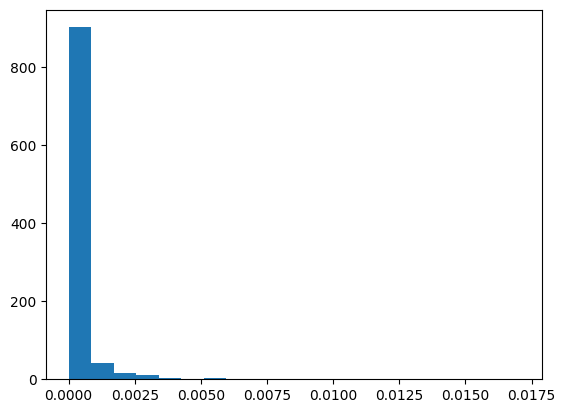

In [9]:
plt.hist(betweenness.values(),bins=20);

In [10]:
betweenness_threshold = 0.0005
G = G_unfiltered.copy()
for edge, value in betweenness.items():
  if value < betweenness_threshold:
    G.remove_edge(edge[0], edge[1])


## Generic Network Layout



In [11]:
# Spring layout again
pos = nx.spring_layout(G, dim=3)


## Plotly Preview


### Define The Function `plotly_preview`

In [14]:

import plotly.offline
def plotly_preview(G, pos, node_colors=None, edge_colors=None):

    """
    Generate a 3D network visualization using Plotly.

    Parameters:
        - G (networkx.Graph): The graph object representing the network.
        - pos3D (dict): A dictionary mapping each node to its 3D coordinates (x, y, z).
        - node_colors (dict, optional): A dictionary mapping nodes to custom hex colors.
                                        If not provided, the default color is '#40b9d4'.
        - edge_colors (dict, optional): A dictionary mapping edges to custom hex colors.
                                        If not provided, the default color is 'gray'.

    Output:
        - An HTML file named 'network_visualization.html' is generated, which opens in a web browser.

    Example usage:
        node_colors = {1: '#ff0000', 2: '#00ff00', 3: '#0000ff'}
        edge_colors = {(1, 2): '#ff00ff', (2, 3): '#ffff00'}
        pos = nx.spring_layout(G,dim=3)
        plotly_review_2(G, pos, node_colors, edge_colors)
    """

    # Create a Plotly figure
    fig = go.Figure()

    # Add nodes to the figure
    for node in G.nodes():
        x, y, z = pos[node]
        color = node_colors[node] if node_colors and node in node_colors else '#40b9d4'
        fig.add_trace(go.Scatter3d(
            x=[x],
            y=[y],
            z=[z],
            mode='markers',
            marker=dict(
                size=5,
                color=color,
            ),
            name=str(node),
            text=str(node),
            hovertemplate=None,
        ))

    # Add edges to the figure
    for edge in G.edges():
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_color = edge_colors[edge] if edge_colors and edge in edge_colors else 'gray'
        fig.add_trace(go.Scatter3d(
            x=[x0, x1],
            y=[y0, y1],
            z=[z0, z1],
            mode='lines',
            line=dict(
                color=edge_color,
                width=1,
            ),
            hoverinfo='none',
        ))

    # Set layout options
    fig.update_layout(
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
        ),
        showlegend=False,
        hovermode='closest',
        margin=dict(l=0, r=0, b=0, t=0),
    )

    # Display the plot inline in the notebook
    iplot(fig)
    plotly.offline.plot(fig, filename='plotly_plot.html')


### Use the Function

In [15]:
plotly_preview(G, pos)


## Export JSON




## Add GO Term Annotations to Genes

In [ ]:
# Alternatively, you can download GO annotations so
# you can select genes annotated with a particular GO term
!wget http://geneontology.org/gene-associations/goa_human.gaf.gz
!gunzip goa_human.gaf.gz

# you can uuse this code to convert e.g. gene symbols to entrez
!wget https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/json/locus_groups/protein-coding_gene.json
# use the name mapper to convert whatever naming system we have
# in the gene list can be converted to entrez
import json
name_mapper = json.load(open("protein-coding_gene.json"))['response']['docs']
symbol_entrez = {i['symbol']:i['entrez_id'] for i in name_mapper}

In [ ]:
import pandas as pd
import json

# Read the gene annotations from the file
go_annotations = pd.read_csv("goa_human.gaf", skiprows=41, sep="\t", header=None)
# Specify the column indices for gene and GO terms
gene_column = 2
go_column = 4

# Download the GO ontology file
!wget http://current.geneontology.org/ontology/go-basic.json
# Load the GO ontology file
go_info = json.load(open("go-basic.json"))
# Create a dictionary mapping GO IDs to their corresponding names
go_id_to_name = {i["id"].split("/")[-1].replace("_", ":"): i['lbl'] for i in go_info['graphs'][0]['nodes'] if 'lbl' in i.keys()}


# Create a dictionary to store gene annotations
annotations = {}
# Process each gene column in the dataframe
for gene in df.columns:
    # Select rows where the gene column matches the current gene
    # NB: if you have different gene identifiers in your own dataset
    # you will have to adjust this line to select the right GO terms
    selected_rows = go_annotations[gene_column] == gene

    # Get unique GO IDs associated with the current gene
    go_ids = set(go_annotations[selected_rows][go_column])

    # Map GO IDs to their corresponding names and store them in the annotations dictionary
    annotations[gene] = [go_id_to_name[go_id] for go_id in go_ids]



### Define Function `make_json`

In [ ]:

def make_json(name, network, positions, node_color = '#40b9d4', link_color = '#999999', annotations = 'None', communities = 'None'):
    """
    Generates a JSON file from a given network graph using the specified parameters.

    Args:
        name (str, optional): Name of the graph.
        network (networkx.Graph): Network graph object.
        positions (dict): Dictionary mapping node IDs to their positions.
        node_color (dict): Dictionary mapping node IDs to their (hex-)colors.
        link_color (str or dict): (Hex-)color value for all links in the graph or dict with node tuple as key and hex color as value.
        communities (dict): 'None' for no communities (default) or dictionary mapping node IDs to their corresponding community ID.
        annotations (dict): Dictionary mapping node IDs to a list of annotations.

    Returns:
        None

    """

    # --------------------------
    # Generate VR GRAPH
    # --------------------------
    GVR = nx.Graph()
    GVR.graph['name'] = name

    # --------------------------------------
    # LOOKUP FOR NODE NAMES INTO IDs and vv
    # --------------------------------------
    d_idx_node = {}
    d_node_idx = {}
    for i, node in enumerate(sorted(network.nodes())):
        d_idx_node[i] = node
        d_node_idx[node] = i
    GVR.add_nodes_from(d_idx_node.keys())

    for edge in network.edges()(data=True):
        GVR.add_edge(d_node_idx[edge[0]],d_node_idx[edge[1]])

    # --------------------------
    # POS
    # --------------------------
    if isinstance(positions[next(iter(positions))], list):
        pass
    else:
        for key in positions:
            positions[key] = positions[key].tolist()

    posG = {d_node_idx[node]: list(xyz) for node, xyz in positions.items()}
    nx.set_node_attributes(GVR, posG, name="pos")

    # # --------------------------
    # # CLUSTER
    # # --------------------------
    if communities == 'None':
        dict_for_cluster = dict(zip(d_idx_node.keys(), [0 for _ in d_idx_node.keys()]))
    else:
        d_VRids_cluster = {d_node_idx[node]: str(cl_id) for node, cl_id in communities.items()}
        nx.set_node_attributes(GVR, d_VRids_cluster, name="cluster")


    # --------------------------
    # NODE COLOR
    # --------------------------
    d_node_colors={}

    if isinstance(node_color, dict):
        for nodeid in GVR.nodes():
            d_node_colors[nodeid] = node_color[d_idx_node[nodeid]]
    else:
        for nodeid in GVR.nodes():
            d_node_colors[nodeid] = node_color

    nx.set_node_attributes(GVR, d_node_colors, name="nodecolor")

    # --------------------------
    # LINK COLOR
    # --------------------------
    if isinstance(link_color, dict):
        # for different link colors
        d_edge_color = {}
        for a,b in GVR.edges():
            try:
                color = link_color[(d_idx_node[a],d_idx_node[b])]
            except KeyError:
                color = link_color[(d_idx_node[b],d_idx_node[a])]
            d_edge_color[(a,b)] = color
    else:
        # for unique link colors
        d_edge_color = {}
        for a,b in GVR.edges():
            d_edge_color[(a,b)] = link_color

    nx.set_edge_attributes(GVR, d_edge_color, name="linkcolor")

    # --------------------------
    # NODE ANNOTATION
    # --------------------------
    if isinstance(annotations, dict):

        l_annotations = [[str(d_idx_node[nodeid])] + [ annotation for annotation in annotations[d_idx_node[nodeid]]] for nodeid in sorted(GVR.nodes())]
        d_annotations = dict(zip(sorted(GVR.nodes()), l_annotations))
    else:
        d_annotations = {nodeid: [str(d_idx_node[nodeid])] for nodeid in GVR.nodes()}

    nx.set_node_attributes(GVR, d_annotations, name="annotation")

    # --------------------------
    # MAKE JSON fo uploader
    # --------------------------

    G_json = json.dumps(nx.node_link_data(GVR))

    with open(GVR.name, "w") as outfile:
        outfile.write(G_json)


### Run the Function



In [ ]:
make_json("feature_network.json", G, pos)

In [ ]:
import google.colab.files
google.colab.files.download("feature_network.json")